In [19]:
import numpy as np
import cvxpy as cp

In [54]:
def wasserstein_dro(historical_data, epsilon, prediction_horizon=2):
    """
    Wasserstein DRO formulation using CVXPY (dual formulation)
    
    Parameters:
    - historical_data: numpy array of historical observations (N x prediction_horizon)
    - epsilon: Wasserstein ball radius (uncertainty set size)
    - prediction_horizon: dimension of prediction variable
    
    Returns:
    - y: Decision variable (optimal prediction)
    - s: Auxiliary variables for transportation costs
    - lambda_var: Wasserstein radius dual variable
    - constraints: List of constraints
    - objective: DRO objective function
    """
    historical_data = np.array(historical_data)
    N = len(historical_data)
    
    # Variables
    y = cp.Variable(prediction_horizon)  # Prediction variable
    lambda_var = cp.Variable(nonneg=True)  # Wasserstein radius dual variable
    s = cp.Variable(N, nonneg=True)  # Transportation costs (one per sample)
    
    # Constraints
    diffs = cp.norm(historical_data - y, axis=1)  # Vectorized L2 norms
    constraints = [
        diffs <= s,              # Transportation cost constraint
        s <= lambda_var          # Bounded by Wasserstein radius
    ]
    
    objective = cp.Minimize(lambda_var * epsilon + cp.sum(s) / N)
    
    return y, s, lambda_var, constraints, objective

In [62]:
import cvxpy as cp
import numpy as np

def wasserstein_dro(historical_data, epsilon, prediction_horizon=1):
    """
    Wasserstein DRO formulation using CVXPY (dual formulation)
    
    Parameters:
    - historical_data: numpy array of historical observations (N x prediction_horizon)
    - epsilon: Wasserstein ball radius (uncertainty set size)
    - prediction_horizon: dimension of prediction variable
    
    Returns:
    - y: Decision variable (optimal prediction)
    - s: Auxiliary variables for transportation costs
    - lambda_var: Wasserstein radius dual variable
    - problem: CVXPY problem object
    """
    historical_data = np.array(historical_data)
    N = len(historical_data)
    
    # Variables
    y = cp.Variable(prediction_horizon)  # Prediction variable
    lambda_var = cp.Variable(nonneg=True)  # Wasserstein radius dual variable
    s = cp.Variable(N, nonneg=True)  # Transportation costs (one per sample)
    
    # Constraints
    constraints = []
    
    # For each sample, we need: ||x_i - y|| ≤ s_i ≤ λ
    for i in range(N):
        constraints.append(cp.norm(historical_data[i] - y, 2) <= s[i])
        constraints.append(s[i] <= lambda_var)
    
    # Objective: min λε + (1/N)∑s_i
    objective = cp.Minimize(lambda_var * epsilon + cp.sum(s) / N)
    
    problem = cp.Problem(objective, constraints)
    
    return y, s, lambda_var, problem

In [70]:
# Example usage
data = np.random.normal(1,0.5, 1000)


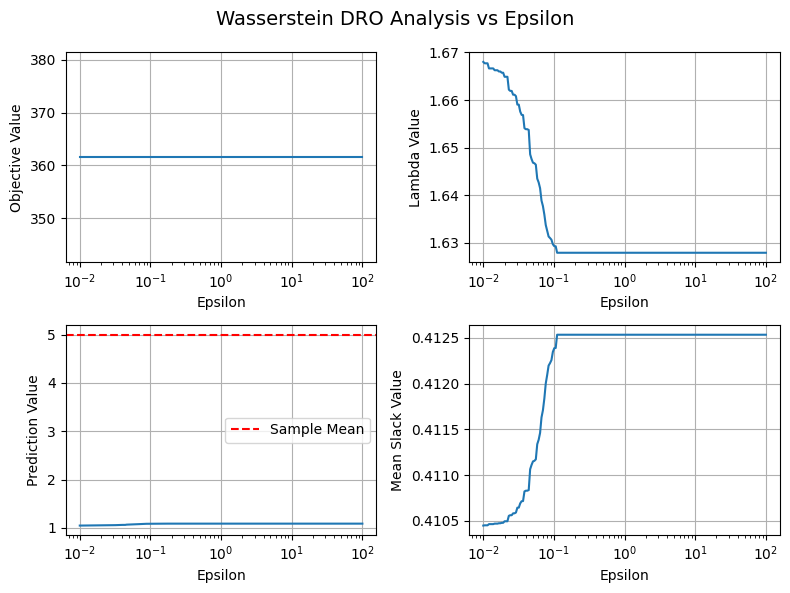


Key observations:
Sample mean: 4.9981
Sample std: 1.0125


In [71]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

# Test range of epsilon values (log scale)
epsilons = np.logspace(-2, 2, 200)
results = []

for epsilon in epsilons:
    y, s, lambda_var, problem = wasserstein_dro(data, epsilon, prediction_horizon=1)
    result = problem.solve(solver=cp.MOSEK)
    
    results.append({
        'epsilon': epsilon,
        'objective': prob.value,
        'lambda': lambda_var.value,
        'prediction': y.value,
        'mean_slack': np.mean(s.value)
    })

# Create plots
fig, axes = plt.subplots(2, 2, figsize=(8, 6))
fig.suptitle('Wasserstein DRO Analysis vs Epsilon', fontsize=14)

# Plot 1: Objective value vs epsilon
axes[0,0].semilogx(epsilons, [r['objective'] for r in results])
axes[0,0].set_xlabel('Epsilon')
axes[0,0].set_ylabel('Objective Value')
axes[0,0].grid(True)

# Plot 2: Lambda vs epsilon
axes[0,1].semilogx(epsilons, [r['lambda'] for r in results])
axes[0,1].set_xlabel('Epsilon')
axes[0,1].set_ylabel('Lambda Value')
axes[0,1].grid(True)

# Plot 3: Prediction vs epsilon
axes[1,0].semilogx(epsilons, [r['prediction'] for r in results])
axes[1,0].axhline(y=np.mean(historical_data), color='r', linestyle='--', label='Sample Mean')
axes[1,0].set_xlabel('Epsilon')
axes[1,0].set_ylabel('Prediction Value')
axes[1,0].legend()
axes[1,0].grid(True)

# Plot 4: Mean slack vs epsilon
axes[1,1].semilogx(epsilons, [r['mean_slack'] for r in results])
axes[1,1].set_xlabel('Epsilon')
axes[1,1].set_ylabel('Mean Slack Value')
axes[1,1].grid(True)

plt.tight_layout()
plt.show()

# Print some key statistics
print("\nKey observations:")
print(f"Sample mean: {np.mean(historical_data):.4f}")
print(f"Sample std: {np.std(historical_data):.4f}")